In [1]:
# # Install packages not present in default Colab environment
# !pip install numpyro posteriordb

In [2]:
# # Get the PosteriorDB
# !git clone https://github.com/stan-dev/posteriordb.git

# 1. PosteriorDB

See https://arxiv.org/abs/2407.04967v1

In [3]:
from posteriordb import PosteriorDatabase
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel

In [4]:
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [5]:
posterior = my_pdb.posterior("diamonds-diamonds")

p_model = posterior.model
p_data = posterior.data

## 1.1. Accessing the data

In [6]:
p_data.information

{'name': 'diamonds',
 'keywords': ['ggplot2', 'tidyverse'],
 'title': 'Diamonds data frame for brms generated by brms::make_standata',
 'description': 'ggplot2 Diamonds data set for brms',
 'urls': 'https://github.com/bbbales2/cmdstan-warmup/blob/develop/examples/diamonds',
 'references': 'wickham2016ggplot2',
 'added_date': '2020-02-01',
 'added_by': 'Oliver Järnefelt'}

In [7]:
print(p_data.information["description"])

ggplot2 Diamonds data set for brms


In [8]:
values_dict = p_data.values()
for key, vals in values_dict.items():
    print(f"{key}: {type(vals)}")

N: <class 'int'>
Y: <class 'list'>
K: <class 'int'>
X: <class 'list'>
prior_only: <class 'int'>


In [9]:
data = {key: np.array(val) for key, val in values_dict.items() if type(val) is list}
data_rest = {key: val for key, val in values_dict.items() if type(val) is not list}

## 1.2. Accessing the model

In [10]:
p_model.information

{'name': 'diamonds',
 'keywords': ['stan_benchmark', 'linear regression'],
 'title': 'Multiple Highly Correlated Predictors Log-Log Model',
 'prior': {'keywords': 'stan_recommended_35dbfe6'},
 'description': 'log(price) ~ carat * (log(x) + log(y) + log(z)) + cut + color + clarity',
 'urls': 'https://github.com/bbbales2/cmdstan-warmup/blob/develop/examples/diamonds',
 'references': 'bales2019selecting',
 'added_date': '2020-02-01',
 'added_by': 'Oliver Järnefelt'}

In [11]:
print(p_model.stan_code())

// generated with brms 2.10.0

functions {
  
}
data {
  int<lower=1> N; // number of observations
  vector[N] Y; // response variable
  int<lower=1> K; // number of population-level effects
  matrix[N, K] X; // population-level design matrix
  int prior_only; // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc; // centered version of X without an intercept
  vector[Kc] means_X; // column means of X before centering
  for (i in 2 : K) {
    means_X[i - 1] = mean(X[ : , i]);
    Xc[ : , i - 1] = X[ : , i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b; // population-level effects
  // temporary intercept for centered predictors
  real Intercept;
  real<lower=0> sigma; // residual SD
}
transformed parameters {
  
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 1);
  target += student_t_lpdf(Intercept | 3, 8, 10);
  target += student_t_lpdf(sigma | 3, 0, 10)
            - 1 * student_t_lccdf(0 | 3, 0, 10);
  // l

## 1.3. Accessing the posterior

In [12]:
posterior.information

{'keywords': ['stan benchmark', 'linear regression', 'pathfinder paper'],
 'urls': 'https://github.com/bbbales2/cmdstan-warmup/blob/develop/examples/diamonds',
 'references': ['bales2019selecting', 'wickham2016ggplot2'],
 'dimensions': {'b': 24, 'Intercept': 1, 'sigma': 1},
 'added_date': '2020-02-01',
 'added_by': 'Oliver Järnefelt'}

In [13]:
posterior.name

'diamonds-diamonds'

In [14]:
posterior.reference_draws_info()['inference']

{'method': 'stan_sampling',
 'method_arguments': {'chains': 10,
  'iter': 20000,
  'warmup': 10000,
  'thin': 10,
  'seed': 4711,
  'control': {'adapt_delta': 0.99, 'max_treedepth': 20}}}

In [15]:
posterior.reference_draws_info()["diagnostics"]

{'diagnostic_information': {'names': ['b[1]',
   'b[2]',
   'b[3]',
   'b[4]',
   'b[5]',
   'b[6]',
   'b[7]',
   'b[8]',
   'b[9]',
   'b[10]',
   'b[11]',
   'b[12]',
   'b[13]',
   'b[14]',
   'b[15]',
   'b[16]',
   'b[17]',
   'b[18]',
   'b[19]',
   'b[20]',
   'b[21]',
   'b[22]',
   'b[23]',
   'b[24]',
   'Intercept',
   'sigma']},
 'ndraws': 10000,
 'nchains': 10,
 'effective_sample_size_bulk': [9887.7459603498,
  10310.438346761,
  10137.7414052872,
  10136.1230533179,
  10057.2361933595,
  9730.31848970419,
  9574.49918784441,
  9846.43494375318,
  9861.5479075935,
  10118.422678104,
  9964.0802437337,
  10171.9101417965,
  9892.86685555493,
  9628.9211135197,
  9934.00450797643,
  9527.67038371501,
  10105.2621133498,
  10106.4605745892,
  9921.45279461561,
  10165.0651379118,
  10104.7170513001,
  9975.19365420567,
  9976.0976472878,
  10049.5584138559,
  9947.6813758736,
  10051.4476397944],
 'effective_sample_size_tail': [9999.00820858923,
  9911.87449276965,
  9614.38

Convergence diagnostic $\hat{R}$ is used: https://doi.org/10.1214/20-BA1221

In [16]:
reference_draws = posterior.reference_draws()
len(reference_draws)

10

Data structure:

[

    {                     - chain1
        param1: [...],
        param2: [...],
        ...
    },
    
    {...},                - chain2,

    ...
    
    {...}                 - chain10
]

In [17]:
reference_draws[0].keys()

dict_keys(['b[1]', 'b[2]', 'b[3]', 'b[4]', 'b[5]', 'b[6]', 'b[7]', 'b[8]', 'b[9]', 'b[10]', 'b[11]', 'b[12]', 'b[13]', 'b[14]', 'b[15]', 'b[16]', 'b[17]', 'b[18]', 'b[19]', 'b[20]', 'b[21]', 'b[22]', 'b[23]', 'b[24]', 'Intercept', 'sigma'])

In [18]:
# Combine all chain draws into a single DataFrame and add chain identifier
reference_draws_df = pd.concat([
    pd.DataFrame(chain_draw).assign(chain_id=i)
    for i, chain_draw in enumerate(reference_draws)
])

# reference_draws_df["step"] = reference_draws_df.index

# Rename beta columns to adjust the indices for later usage
# reference_draws_df.rename(columns={f"beta[{i+1}]": f"beta[{i}]" for i in range(3)}, inplace=True)

reference_draws_df

,b[1],b[2],b[3],b[4],b[5],b[6],b[7],b[8],b[9],b[10],...,b[18],b[19],b[20],b[21],b[22],b[23],b[24],Intercept,sigma,chain_id
0,6.558847,6.105568,-4.492008,1.568187,0.135701,-0.042189,0.024993,0.005900,-0.447776,-0.093153,...,-0.061160,0.019884,-0.007028,0.025016,-5.757860,4.384663,-1.532415,7.792967,0.123401,0
1,6.852109,6.088976,-4.309645,1.302592,0.138684,-0.050193,0.033765,-0.001087,-0.450925,-0.093300,...,-0.048296,0.022392,-0.000269,0.026784,-5.822103,4.250303,-1.427493,7.788057,0.122009,0
2,6.650531,6.013908,-4.449779,1.573739,0.124625,-0.032638,0.019638,-0.004168,-0.446881,-0.101230,...,-0.049002,0.018172,0.006315,0.038363,-5.865965,4.396349,-1.451338,7.789234,0.123128,0
3,6.745017,6.412219,-4.962492,1.620767,0.140603,-0.044739,0.028786,-0.000455,-0.444529,-0.095642,...,-0.052483,0.022589,-0.000317,0.026576,-5.878313,4.555128,-1.685576,7.788277,0.124471,0
4,6.529848,6.296251,-4.852639,1.725669,0.127325,-0.035958,0.021422,-0.002392,-0.446059,-0.098158,...,-0.061284,0.009773,-0.009712,0.029008,-6.053156,4.705672,-1.548416,7.791229,0.123913,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.025499,6.244067,-4.727564,1.473449,0.119349,-0.024811,0.012453,0.002247,-0.444085,-0.097014,...,-0.067020,0.016457,-0.003508,0.031003,-6.246064,4.775748,-1.638362,7.786106,0.124281,9
996,6.368991,6.570109,-4.979740,1.633528,0.129311,-0.037383,0.019042,0.000066,-0.443848,-0.086430,...,-0.067332,0.018883,-0.001965,0.025891,-6.231889,4.953932,-1.550342,7.786309,0.121693,9
997,7.341036,6.242754,-4.952205,1.537745,0.122536,-0.034910,0.019735,0.011126,-0.448693,-0.100573,...,-0.062113,0.019496,-0.003769,0.029488,-6.199628,4.750627,-1.818325,7.787158,0.126018,9
998,6.347526,6.585266,-4.729307,1.398987,0.146274,-0.048597,0.020630,0.004267,-0.453920,-0.091332,...,-0.065856,0.027186,-0.005134,0.031181,-6.160192,4.674922,-1.279399,7.788346,0.122748,9


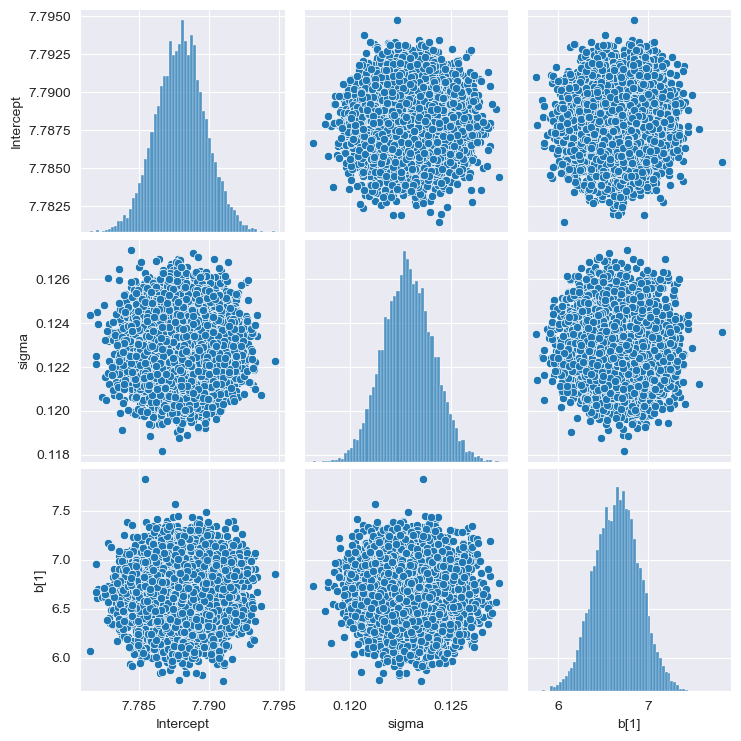

In [19]:
sns.pairplot(reference_draws_df, vars=["Intercept", "sigma", "b[1]"])

In [20]:
# sns.scatterplot(reference_draws_df, x=reference_draws_df.index, y="sigma", marker='.')

In [21]:
reference_draws_df.drop(columns=["chain_id"], inplace=True)

# 2. NumPyro

See https://num.pyro.ai/en/latest/index.html

In [22]:
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model
from jax import random
import jax.numpy as jnp

## 2.1. Specifying the model

In [23]:
print(p_model.stan_code())

// generated with brms 2.10.0

functions {
  
}
data {
  int<lower=1> N; // number of observations
  vector[N] Y; // response variable
  int<lower=1> K; // number of population-level effects
  matrix[N, K] X; // population-level design matrix
  int prior_only; // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc; // centered version of X without an intercept
  vector[Kc] means_X; // column means of X before centering
  for (i in 2 : K) {
    means_X[i - 1] = mean(X[ : , i]);
    Xc[ : , i - 1] = X[ : , i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b; // population-level effects
  // temporary intercept for centered predictors
  real Intercept;
  real<lower=0> sigma; // residual SD
}
transformed parameters {
  
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 1);
  target += student_t_lpdf(Intercept | 3, 8, 10);
  target += student_t_lpdf(sigma | 3, 0, 10)
            - 1 * student_t_lccdf(0 | 3, 0, 10);
  // l

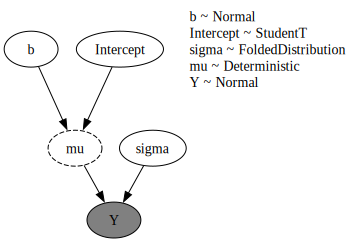

In [109]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random

def model(Y, X):
    # Data transformation
    N, K = X.shape
    Kc = K - 1
    means_X = jnp.mean(X[:, 1:], axis=0)  # Means of columns excluding the first (intercept)
    Xc = jnp.column_stack([X[:, 0], X[:, 1:] - means_X])  # Center the predictors

    # Priors
    b = numpyro.sample("b", dist.Normal(loc=0, scale=1), sample_shape=(Kc, ))
    Intercept = numpyro.sample("Intercept", dist.StudentT(df=3, loc=8, scale=10))
    sigma = numpyro.sample("sigma", dist.FoldedDistribution(dist.StudentT(df=3, loc=0, scale=10)))
    # sigma = numpyro.deterministic("sigma", jnp.abs(sigma_base))

    # Likelihood
    mu = numpyro.deterministic("mu", Intercept + jnp.dot(Xc[:, 1:], b))
    # mu = Intercept + jnp.dot(Xc[:, 1:], b)# Linear predictor without intercept from Xc
    numpyro.sample("Y", dist.Normal(mu, sigma), obs=Y)

# render_model(model, model_kwargs=data, render_distributions=True, filename="/Users/mikhail/Master/adaptive-mcmc/img/svg/model_diamonds.svg")

## 2.2. Specifying the kernel

Or use Sample Adaptive MCMC kernel from https://proceedings.neurips.cc/paper_files/paper/2019/file/2cfa8f9e50e0f510ede9d12338a5f564-Paper.pdf

In [105]:
from kernels import ARWMH, ASSS, NUTS
# kernel = ASSS(model)
# kernel = ARWMH(model)
kernel = NUTS(model)

## 2.3 Running MCMC

In [107]:
mcmc = infer.MCMC(kernel, num_warmup=10000, num_samples=10000, thinning=1)
rng_key = random.PRNGKey(0)

mcmc.run(rng_key,
         **data,
         extra_fields=("potential_energy", "adapt_state")
        )

warmup:   4%|▍         | 821/20000 [00:23<09:14, 34.61it/s, 511 steps of size 5.77e-03. acc. prob=0.79] 


KeyboardInterrupt: 

In [90]:
state = mcmc.last_state
state

ARWMHState(i=Array(2000000, dtype=int32, weak_type=True), z={'Intercept': Array(7.7877207, dtype=float32), 'b': Array([ 6.7740536e+00,  6.3686843e+00, -5.0219417e+00,  1.6511110e+00,
        1.3439038e-01, -4.3734435e-02,  2.2074454e-02,  1.3720518e-03,
       -4.4668138e-01, -9.5560238e-02, -5.4776045e-03,  1.8920215e-02,
       -3.6600521e-03,  4.6585654e-03,  9.0166348e-01, -2.2507526e-01,
        1.3176350e-01, -5.8991104e-02,  1.9089252e-02,  1.0725353e-03,
        3.0925881e-02, -6.1105652e+00,  4.7745762e+00, -1.6663884e+00],      dtype=float32), 'sigma': Array(-2.0883439, dtype=float32)}, potential_energy=Array(-3276.6821, dtype=float32), mean_accept_prob=Array(0.23377694, dtype=float32), adapt_state=ARWMHAdaptState(loc=Array([ 7.7879601e+00,  6.6810594e+00,  6.3121548e+00, -4.6849737e+00,
        1.4798034e+00,  1.3584018e-01, -4.1325830e-02,  2.3337279e-02,
        1.3004309e-03, -4.4545469e-01, -9.2914574e-02, -1.1953108e-02,
        1.0859783e-02, -7.9421903e-04,  1.1183447

In [91]:
import pickle
# with open("debug_state.pkl", "wb") as f:
#     pickle.dump(state, f)


In [92]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  Intercept      7.79      0.00      7.79      7.79      7.79    221.96      1.01
       b[0]      6.61      0.20      6.60      6.29      6.93     24.23      1.08
       b[1]      6.20      0.34      6.23      5.66      6.68      6.21      1.32
       b[2]     -4.58      0.28     -4.56     -5.03     -4.18      9.65      1.20
       b[3]      1.52      0.15      1.51      1.32      1.75      6.73      1.26
       b[4]      0.13      0.01      0.13      0.13      0.14   3473.05      1.00
       b[5]     -0.04      0.00     -0.04     -0.05     -0.03    421.87      1.01
       b[6]      0.02      0.00      0.02      0.02      0.03    464.19      1.02
       b[7]      0.00      0.00      0.00     -0.00      0.01    117.84      1.02
       b[8]     -0.45      0.00     -0.45     -0.45     -0.44    440.67      1.01
       b[9]     -0.09      0.00     -0.09     -0.10     -0.09    182.82      1.01
      b[10]    

In [93]:
posterior_samples = mcmc.get_samples()
extra_fields = mcmc.get_extra_fields()

In [94]:
# plt.plot(extra_fields['mean_accept_prob'])
# plt.xlabel("Step")
# plt.ylabel("Mean Acceptance Probability")
# plt.show()

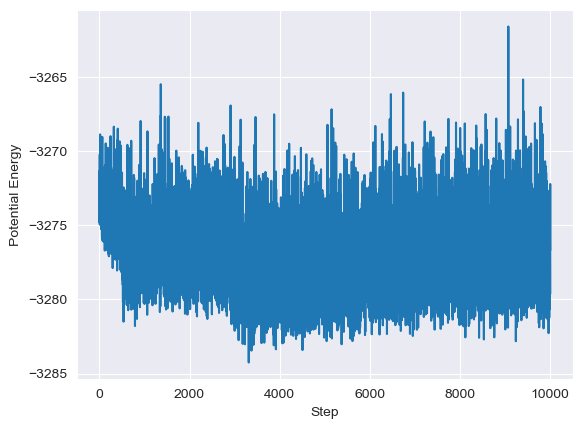

In [95]:
plt.plot(extra_fields["potential_energy"])
plt.xlabel("Step")
plt.ylabel("Potential Energy")
# plt.semilogy()
plt.show()

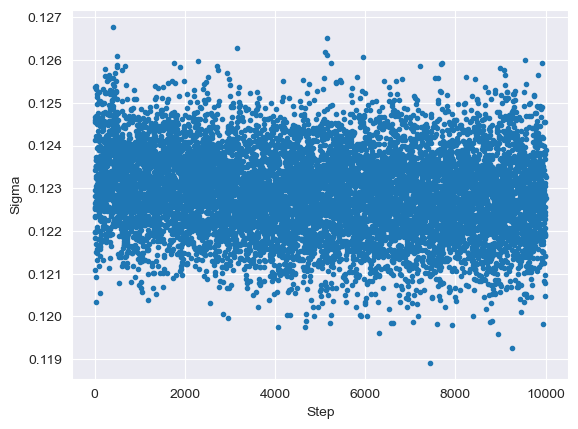

In [96]:
plt.plot(posterior_samples["sigma"], '.')
plt.xlabel("Step")
plt.ylabel("Sigma")
plt.show()

In [97]:
posterior_samples_df = pd.DataFrame({
    k: v
    for key, vals in posterior_samples.items()
    for k, v in ([(key, vals)] if vals.ndim==1 else zip([f"{key}[{i+1}]" for i in range(vals.shape[-1])], vals.T))
})

posterior_samples_df["step"] = posterior_samples_df.index * mcmc.thinning

# posterior_samples_df

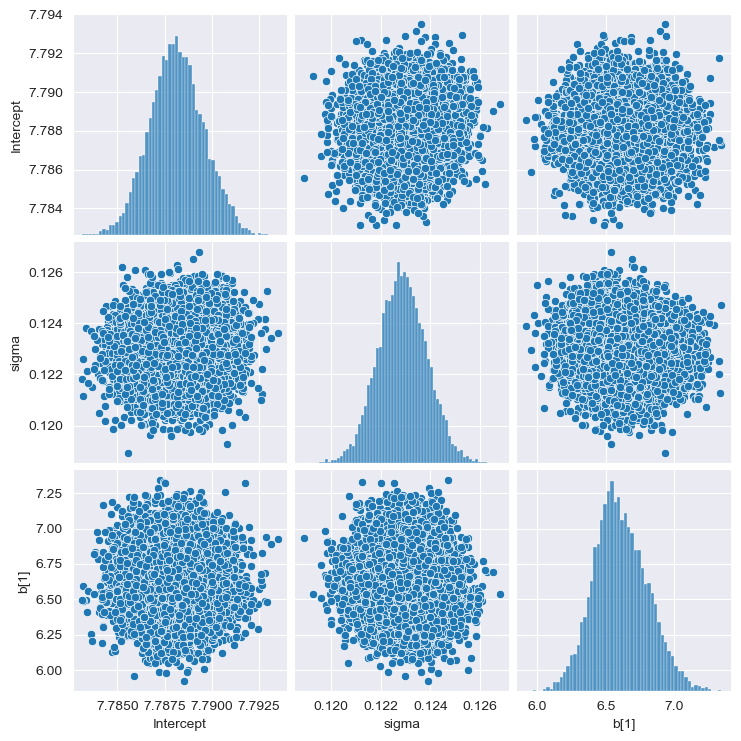

In [98]:
sns.pairplot(posterior_samples_df, vars=["Intercept", "sigma", "b[1]"])

# 3. Evaluation

In [99]:
combined_df = pd.concat([
    reference_draws_df.assign(source = "reference"),
    posterior_samples_df.assign(source = "samples"),
])
# combined_df

In [100]:
# combined_df.to_csv("diamonds-diamonds.csv", index=False)

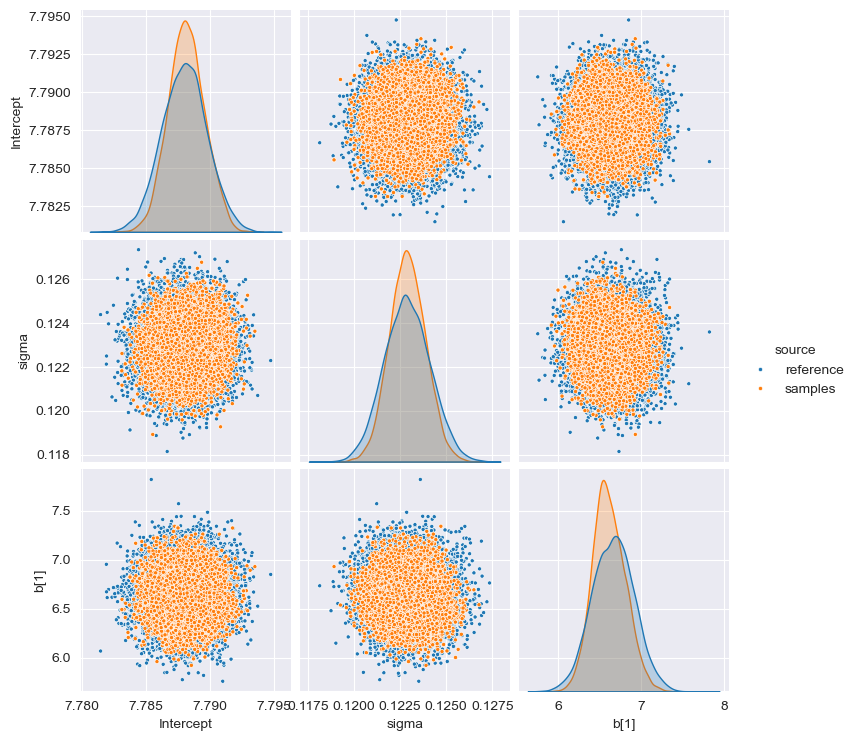

In [101]:
sns.pairplot(combined_df, hue="source", markers=".", vars=["Intercept", "sigma", "b[1]"])
plt.show()

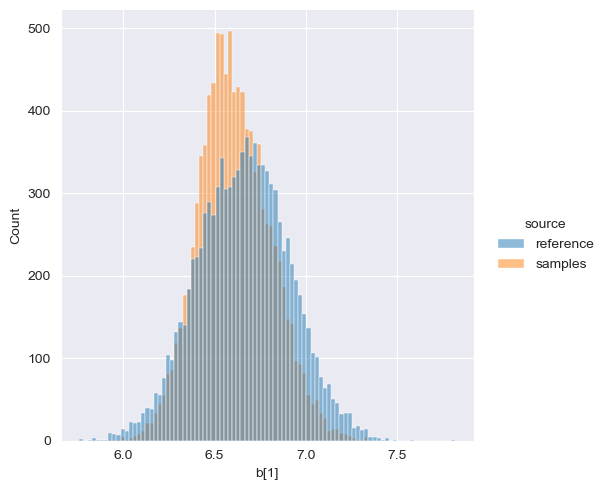

In [102]:
sns.displot(combined_df, x="b[1]", hue="source")
plt.show()

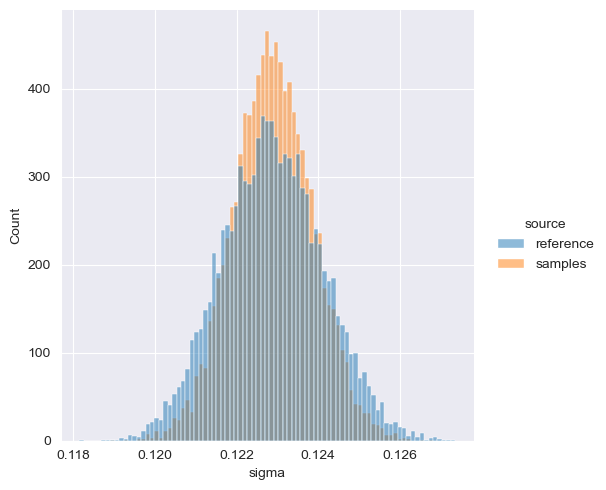

In [103]:
sns.displot(combined_df, x="sigma", hue="source")
plt.show()

In [88]:
arr_reference = jnp.array(combined_df.where(combined_df["source"] == "reference").dropna().drop(columns="source"))
arr_samples = jnp.array(combined_df.where(combined_df["source"] == "samples").dropna().drop(columns="source"))

## 3.1. Moments

RMSE of sampled moments of interest compared to a reference posterior moments

In [44]:
p = 2

pth_moments = combined_df.groupby("source").aggregate(lambda vals: np.mean(vals**p)).transpose().rename_axis(f"E[|X|^{p}]")
pth_moments["diff (%)"] = np.abs(pth_moments["reference"] - pth_moments["samples"])/(pth_moments["reference"])*100

pth_moments

source,reference,samples,diff (%)
E[|X|^2],,,
b[1],44.417422,6.083880e+00,8.630294e+01
b[2],40.598356,1.378236e+01,6.605193e+01
b[3],22.040444,3.356039e-01,9.847733e+01
b[4],2.113180,2.768752e+00,3.102300e+01
b[5],0.018108,4.316961e-01,2.283993e+03
b[6],0.001659,4.779893e-01,2.870992e+04
b[7],0.000552,3.716505e-01,6.717006e+04
b[8],0.000024,1.596740e-01,6.753598e+05
b[9],0.197932,3.197113e-01,6.152579e+01


In [45]:
from evaluation import pth_moment_rmse

ModuleNotFoundError: No module named 'evaluation'

In [129]:
%%time
pth_moment_rmse(x, y)

CPU times: user 841 μs, sys: 305 μs, total: 1.15 ms
Wall time: 672 μs


Array(5.2735467, dtype=float32)

In [133]:
n = 10000
x = arr_reference[:n]
y = arr_samples[:n]

## 3.2. Wasserstein-1 Distance

$$ \mathcal{W}(u, v) = \inf_{\xi \in \mathcal{C} (u, v)} \int \| x-y \|_2 \xi (dx,dy) $$

### 3.2.1. Optimal 1-1 coupling

In [134]:
from utils.evaluation import wasserstein_dist11_p

In [135]:
%%time
wasserstein_dist11_p(x, y)

CPU times: user 1.21 ms, sys: 2.07 ms, total: 3.28 ms
Wall time: 3.51 ms


/Users/mikhail/Master/adaptive-mcmc/python/utils/evaluation.py:65: RuntimeWarning: Mean of empty slice.
  opt_cost = cost_matrix[row_ind, col_ind].mean().item()
/Users/mikhail/miniconda3/envs/mcmc/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [47]:
solve_fn = jit(linear.solve)

def wasserstein_distance_ot(u_values, v_values), cost_fn=costs.Euclidean():
    geom = pointcloud.PointCloud(x=u_values, y=v_values, cost_fn=cost_fn)
    ot = solve_fn(geom)
    return ot.primal_cost.item()

In [73]:
# geom = pointcloud.PointCloud(x=x, y=y, cost_fn=costs.Euclidean())
# solve_fn = jit(linear.solve)
# ot = solve_fn(geom)

# print(
#     " Sinkhorn has converged: ",
#     ot.converged,
#     "\n",
#     "Error upon last iteration: ",
#     ot.errors[(ot.errors > -1)][-1],
#     "\n",
#     "Sinkhorn required ",
#     jnp.sum(ot.errors > -1),
#     " iterations to converge. \n",
#     "Entropy regularized OT cost: ",
#     ot.ent_reg_cost,
#     "\n",
#     "OT cost (without entropy): ",
#     jnp.sum(ot.matrix * ot.geom.cost_matrix),
# )

In [48]:
%%time

wasserstein_distance_ot(x, y)

CPU times: user 4.82 s, sys: 2.07 s, total: 6.89 s
Wall time: 2.79 s


2.876431941986084

In [93]:
def wasserstein_1d(mu, nu, p=2.0):
    """
    Compute the 1D Wasserstein distance between two arrays.
    
    Parameters:
    - mu, nu: 1D arrays.
    
    Returns:
    - float: The Wasserstein distance in 1D.
    """

    # Compute the absolute differences
    diff = jnp.abs(jnp.sort(mu) - jnp.sort(nu))
    
    # Raise to the power of p
    diff_p = diff ** p
    
    # Compute the p-th root of the sum of differences to the power p
    return jnp.power(jnp.mean(diff_p), 1.0 / p)


def max_sliced_wasserstein(mu, nu, rng_key, p=2.0, n_directions=1000):
    """
    Approximate the Wasserstein distance using the max-sliced approach with JAX.

    Parameters:
    - mu, nu: jnp.arrays of shape (n_samples, n_dimensions) representing 
              points sampled from two distributions.
    - key: JAX PRNG key for randomness.
    - n_directions: Number of random directions to project onto.

    Returns:
    - float: An approximation of the Wasserstein distance.
    """
    n_dim = mu.shape[1]
    
    # Generate random directions on the unit sphere
    directions = random.normal(rng_key, (n_directions, n_dim))
    directions = directions / jnp.linalg.norm(directions, axis=1, keepdims=True)
    
    # Vectorizing projection and 1D Wasserstein computation over directions
    project_and_compute = vmap(lambda dir: wasserstein_1d(
        jnp.dot(mu, dir),
        jnp.dot(nu, dir),
        p=p
    ))
    
    distances = project_and_compute(directions)
    
    return jnp.max(distances)

In [94]:
%%time

rng_key, key_wasserstein = random.split(rng_key, 2)
max_sliced_wasserstein(x, y, key_wasserstein, n_directions=10000).item()

CPU times: user 26.2 s, sys: 481 ms, total: 26.7 s
Wall time: 26 s


1.9741389751434326

In [ ]:
%%time

wasserstein_distance_nd(x, y)

## 3.3. Maximum Mean Discrepancy

Given a symmetric, positive-definite kernel kernel $k(\cdot,\cdot): \mathcal{X} \times \mathcal{X} \to \mathbb{R}$,
the MMD between distributions $P$ and $Q$ is given by

$$ MMD(P, Q)^2 = \int_{\mathcal{X} \times \mathcal{X}} k(x, x') P(dx)P(dx') + \int_{\mathcal{X} \times \mathcal{X}} k(y, y') Q(dy)Q(dy') - 2\int_{\mathcal{X} \times \mathcal{X}} k(x, y) P(dx)Q(dy) $$

Unbiased estimator:

$$ MMD(\widehat{P}_n, \widehat{Q}_m)^2 = \frac{1}{n(n-1)}\sum_{i \neq i'}k(x_i, x_{i'}) + \frac{1}{m(m-1)}\sum_{j \neq j'}k(y_j, y_{j'}) - \frac{2}{mn}\sum_{i, j}k(x_i, y_j) $$

Usually Gaussian kernel is used with

$$ k(x,y) := \exp \left( -\gamma \| x-y \|^2 \right) $$.


In [91]:
def gaussian_kernel(x, y, gamma):
    """
    Compute the Gaussian kernel between vectors x and y.
    
    :param x: Jax array of shape (n, d)
    :param y: Jax array of shape (m, d)
    :param gamma: Bandwidth parameter for the Gaussian kernel
    :return: Jax array of shape (n, m)
    """

    eucl_dist2 = jnp.sqrt(((x[:, None, :] - y[None, :, :]) ** 2).sum(-1))
    
    return jnp.exp(-gamma * eucl_dist2)

@jit
def mmd_unbiased(x, y, gamma=1.0):
    """
    Compute the unbiased MMD estimator between two sets of samples.

    :param x: Jax array of shape (n, d)
    :param y: Jax array of shape (m, d)
    :param gamma: Bandwidth parameter for the Gaussian kernel
    :return: Scalar value representing the MMD^2
    """
    n = x.shape[0]
    m = y.shape[0]
    
    # Compute kernel matrices
    Kxx = gaussian_kernel(x, x, gamma)
    Kyy = gaussian_kernel(y, y, gamma)
    Kxy = gaussian_kernel(x, y, gamma)

    # Diagonal elements set to 0 for the unbiased estimator
    Kxx = Kxx.at[jnp.arange(n), jnp.arange(n)].set(0)
    Kyy = Kyy.at[jnp.arange(m), jnp.arange(m)].set(0)
    
    # Compute each term in the MMD formula
    mmd = jnp.sum(Kxx) / (n * (n - 1)) + jnp.sum(Kyy) / (m * (m - 1)) - 2 * jnp.sum(Kxy) / (n * m)
    
    return mmd

In [92]:
%%time
mmd_unbiased(x, y).item()

CPU times: user 1.34 s, sys: 15.1 ms, total: 1.36 s
Wall time: 299 ms


0.8688206076622009

## 3.4. Pareto-$\hat{k}$ diagnostic

See https://arxiv.org/abs/1507.02646